<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 
# Project 4: Applying Unsupervised Learning Algorithms

---

## Description

The project is about Historical NASDAQ stock data of tech companies dubbed: 'Big Five' until August 23rd, 2019. The companies are: Apple, Google, Amazon, Facebook, and Microsoft. We will be focusing on predicting the value of
closing price of Apple company. Analyzing the company’s future profitability on the basis of its current business environment and financial performance using time series forecasting.  

### Contents:
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)

&nbsp;
&nbsp;

## Importing Libraries

In [22]:
import re
import pandas as pd
import numpy as np
# import arabic_reshaper
# from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA, AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


## Data Import & Cleaning

In [2]:
# Read dataset
stocks  = pd.read_csv('big_five_stocks.csv')

In [3]:
# check head
stocks.head()

,Unnamed: 0,name,open,close,high,low,volume
0,1971-02-05,^IXIC,100.00,100.00,100.00,100.00,0.0
1,1971-02-08,^IXIC,100.84,100.84,100.84,100.84,0.0
2,1971-02-09,^IXIC,100.76,100.76,100.76,100.76,0.0
3,1971-02-10,^IXIC,100.69,100.69,100.69,100.69,0.0
4,1971-02-11,^IXIC,101.45,101.45,101.45,101.45,0.0


In [4]:
# rename feature to appropriate
stocks.rename(columns={"Unnamed: 0":"date"},inplace = True )

In [5]:
# check for nulls
stocks.isnull().sum()

date      0
name      0
open      0
close     0
high      0
low       0
volume    0
dtype: int64

In [6]:
# check types 
stocks.dtypes

date       object
name       object
open      float64
close     float64
high      float64
low       float64
volume    float64
dtype: object

In [7]:
# change date to appropriate type(date)
stocks.date = pd.to_datetime(stocks.date)
stocks.dtypes

date      datetime64[ns]
name              object
open             float64
close            float64
high             float64
low              float64
volume           float64
dtype: object

In [8]:
stocks.describe()

,open,close,high,low,volume
count,41660.000000,41660.000000,41660.000000,41660.000000,4.166000e+04
mean,592.565369,592.482337,596.681878,587.823401,1.195606e+07
std,1254.603123,1254.463915,1262.142541,1245.789816,2.156350e+07
min,0.090000,0.090000,0.090000,0.090000,0.000000e+00
25%,16.687500,16.727500,17.060000,16.337500,0.000000e+00
50%,89.255000,89.360000,89.875000,88.615000,2.302950e+06
75%,407.637500,407.775000,409.602500,405.975000,1.401524e+07
max,8325.100000,8330.210000,8339.640000,8291.120000,5.910786e+08


## Exploratory Data Analysis

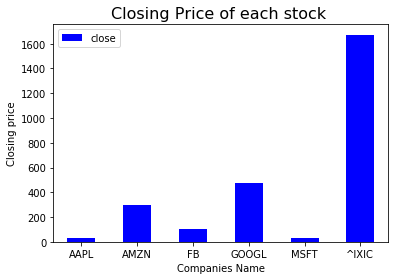

In [9]:
#pivot table of Overall Quality & Sale price
quality_pivot = stocks.pivot_table(index= 'name', values= 'close')

#plotting the pivot table

quality_pivot.plot(kind = 'bar', color = 'blue')

plt.xlabel('Companies Name')
plt.ylabel('Closing price')
plt.xticks(rotation = 0)
plt.title('Closing Price of each stock ',fontsize=16);
plt.show();

In [10]:
# Chosing company 
stocks.groupby('name').count()

,date,open,close,high,low,volume
name,,,,,,
AAPL,9760,9760,9760,9760,9760,9760
AMZN,5607,5607,5607,5607,5607,5607
FB,1828,1828,1828,1828,1828,1828
GOOGL,3780,3780,3780,3780,3780,3780
MSFT,8433,8433,8433,8433,8433,8433
^IXIC,12252,12252,12252,12252,12252,12252


So we chose AAPL because it has the highest rows count for simplicity, Therfore We aim to predict the daily adjusted closing prices AAPL.

In [11]:
#Select Apple company info and index date
stocks_AAPL = stocks[stocks['name']=="AAPL"]
stocks_AAPL.set_index("date", inplace = True)

In [12]:
stocks_AAPL.head()

,name,open,close,high,low,volume
date,,,,,,
1980-12-12,AAPL,0.51,0.51,0.52,0.51,2093900.0
1980-12-15,AAPL,0.49,0.49,0.49,0.49,785200.0
1980-12-16,AAPL,0.45,0.45,0.45,0.45,472000.0
1980-12-17,AAPL,0.46,0.46,0.46,0.46,385900.0
1980-12-18,AAPL,0.48,0.48,0.48,0.48,327900.0


#### Close Feature

In [13]:
stocks_AAPL_close = stocks_AAPL[["close"]]

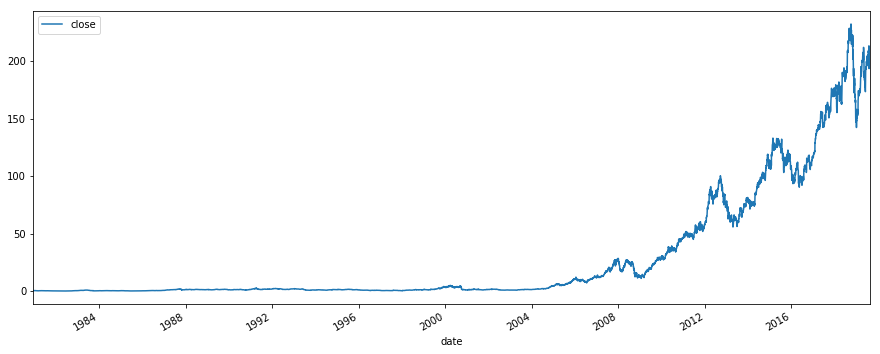

In [14]:
## Close Feature
stocks_AAPL_close.plot(figsize=(15, 6))
plt.show();

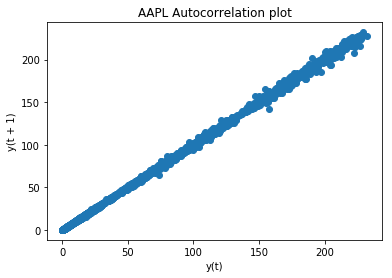

In [15]:
### closing price prediction
lag_plot(stocks_AAPL["close"], lag=1)
plt.title('AAPL Autocorrelation plot');

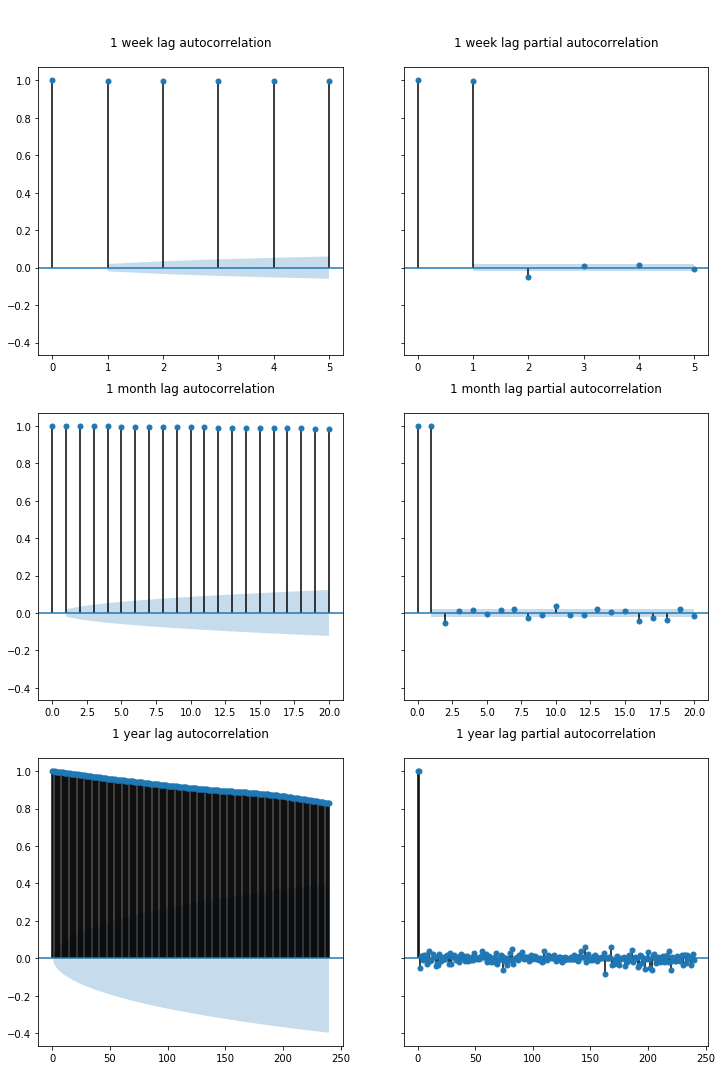

In [16]:
f, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey=True, figsize=(12,18))
week = 5
month = 4
year = 12
# weeks lags
plot_acf(stocks_AAPL_close, ax1, lags=week)
ax1.set_title("\n\n1 week lag autocorrelation\n")
plot_pacf(stocks_AAPL_close, ax2, lags=week)
ax2.set_title("\n\n1 week lag partial autocorrelation\n")

# months lags
plot_acf(stocks_AAPL_close, ax3, lags=month*week)
ax3.set_title("\n\n1 month lag autocorrelation\n")
plot_pacf(stocks_AAPL_close, ax4, lags=month*week)
ax4.set_title("\n\n1 month lag partial autocorrelation\n")

# year lags
plot_acf(stocks_AAPL_close, ax5, lags=year*month*week)
ax5.set_title("\n\n1 year lag autocorrelation\n")
plot_pacf(stocks_AAPL_close, ax6, lags=year*month*week)
ax6.set_title("\n\n1 year lag partial autocorrelation\n")

plt.show()


In [47]:
#convert the data to from weekly to monthly
stocks_AAPL_close = stocks_AAPL_close.resample('MS').mean()

In [50]:
from pylab import rcParams

rcParams['figure.figsize'] = (12,6)

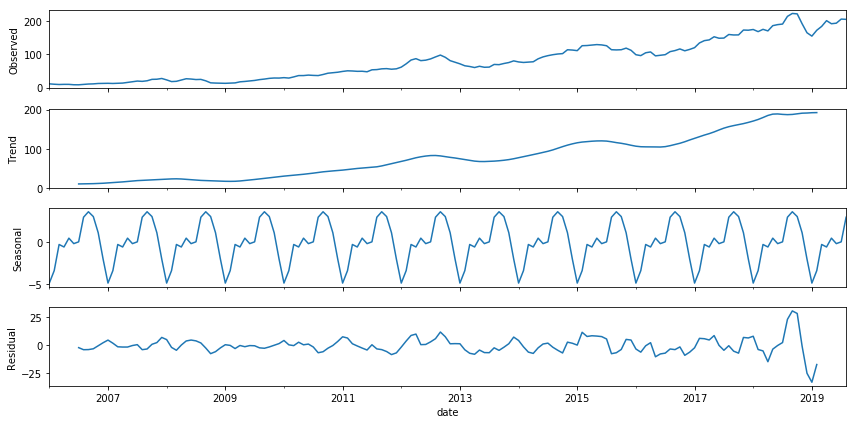

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(stocks_AAPL_close['2006-1-1':], model='additive')
result.plot();

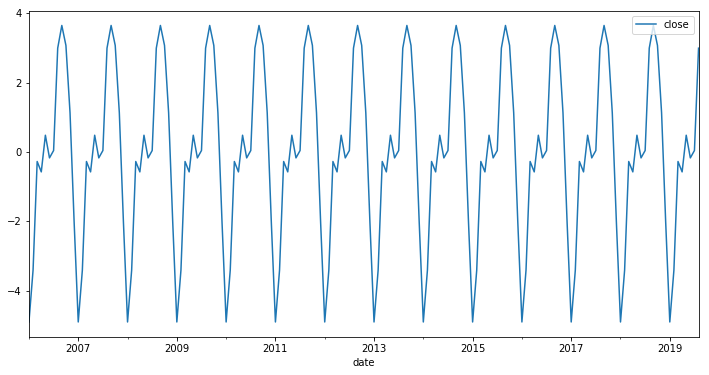

In [52]:
#its clear that the seasonality of the data is on a yearly bases 
result.seasonal.plot();

## Modeling

### Split the data to train and test

In [64]:
# Split the data into train and test

#train %80 and %20 test

train_size = int(len(stocks_AAPL_close)*.8)
train = stocks_AAPL_close['close'][:train_size]
test = stocks_AAPL_close['close'][train_size:]

In [65]:
# check the head
train.head()

date
1980-12-01    0.543077
1981-01-01    0.564762
1981-02-01    0.472105
1981-03-01    0.444091
1981-04-01    0.485714
Freq: MS, Name: close, dtype: float64

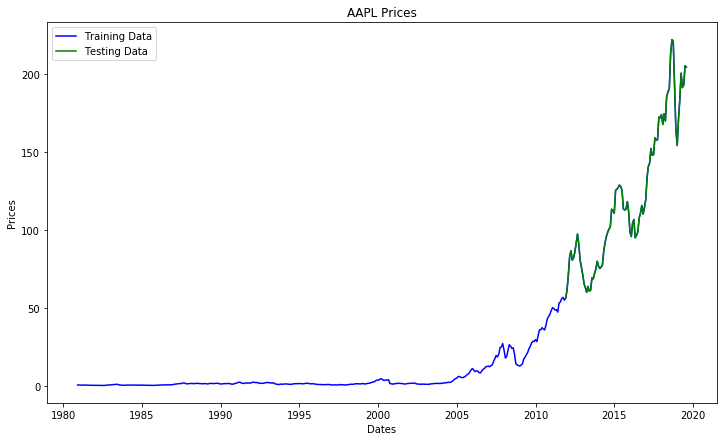

In [67]:
plt.figure(figsize=(12,7))
plt.title('AAPL Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(stocks_AAPL_close['close'], 'blue', label='Training Data')
plt.plot(test, 'green', label='Testing Data')
plt.legend();

### Double Exponential Smoothing

In [68]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing , ExponentialSmoothing
#Train Double Exponential Smoothing model
forecast_model = ExponentialSmoothing(train, trend = 'add'
                                     , seasonal='mul' , seasonal_periods=12 , freq='MS').fit()


In [69]:
#Test Double Exponential Smoothing model
test_pred = forecast_model.forecast(93)

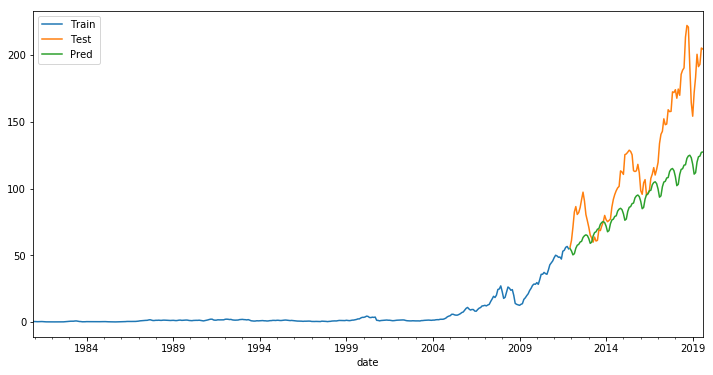

In [70]:
train.plot(figsize = (12,6) , legend = True , label = 'Train');
test.plot(figsize = (12,6) , legend = True , label = 'Test');
test_pred.plot(figsize = (12,6) , legend = True , label = 'Pred');

In [74]:
test.describe()

count     93.000000
mean     120.674954
std       44.818385
min       56.132381
25%       82.500909
50%      111.726818
75%      157.608500
max      222.073684
Name: close, dtype: float64

In [71]:
from sklearn.metrics import mean_absolute_error , mean_squared_error

In [72]:
#Evaluation 
print('Mean absolute error : '  , mean_absolute_error(test,test_pred))
print('Mean squared error : '  , mean_squared_error(test,test_pred))
print('Root mean squared error : '  , np.sqrt(mean_squared_error(test,test_pred)))

Mean absolute error :  31.740922135090532
Mean squared error :  1683.070339659006
Root mean squared error :  41.02524027545733


In [75]:
#Future data 
forecast_model_future = ExponentialSmoothing( stocks_AAPL_close['close'], trend = 'add'
                                     , seasonal='mul' , seasonal_periods=12 , freq='MS').fit()

In [76]:
future_pred = forecast_model_future.forecast(36)

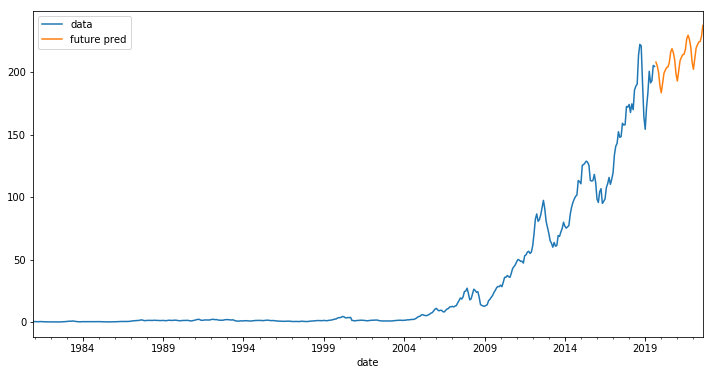

In [77]:
stocks_AAPL_close['close'].plot(figsize = (12,6) , legend = True , label = 'data');
future_pred.plot(figsize = (12,6) , legend = True , label = 'future pred');

In [78]:
# stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,maxlag=None,regression='c',autolag='AIC'):
    '''Perform Dickey-Fuller test and print out results'''
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,regression=regression,autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

test_stationarity(stocks_AAPL.close.diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.619568e+01
p-value                        4.126749e-29
#Lags Used                     3.800000e+01
Number of Observations Used    9.720000e+03
Critical Value (1%)           -3.431023e+00
Critical Value (5%)           -2.861837e+00
Critical Value (10%)          -2.566928e+00
dtype: float64


### ARIMA Model

In [79]:
# instead of grid search, Auto Arima (similar to grid search) 
from pmdarima import auto_arima

stepwise_fit = auto_arima(stocks_AAPL_close['close'], start_p=0 , start_q=0 , max_p=10 , max_q=10 ,
                         seasonal=True , m = 12 , trace = True)

Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 0, 1, 12); AIC=2681.377, BIC=2697.928, Fit time=0.141 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 12); AIC=2707.254, BIC=2715.529, Fit time=0.013 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 0, 12); AIC=2657.980, BIC=2674.531, Fit time=0.157 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 1, 12); AIC=2539.232, BIC=2555.783, Fit time=0.291 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 1, 12); AIC=2540.601, BIC=2561.290, Fit time=0.347 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 12); AIC=2554.288, BIC=2566.701, Fit time=0.221 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 2, 12); AIC=2540.256, BIC=2560.945, Fit time=0.721 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 2, 12); AIC=2530.004, BIC=2554.831, Fit time=1.730 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_orde

In [32]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9760
Model:               SARIMAX(0, 2, 1)   Log Likelihood              -13382.269
Date:                Mon, 02 Sep 2019   AIC                          26770.538
Time:                        12:31:48   BIC                          26792.096
Sample:                             0   HQIC                         26777.844
                               - 9760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.258e-06   7.66e-06      0.686      0.493   -9.76e-06    2.03e-05
ma.L1         -0.9996      0.000  -2419.059      0.000      -1.000      -0.999
sigma2         0.9055      0.003    324.009      0.000       0.900       0.911
===================================================================================
Ljung-Box (Q):                      424.96   Jarque-Bera (JB):            772590.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            2259.40   Skew:                            -1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
# fitting 
arima = ARIMA(train, order=(0, 2, 1)).fit()
arima.aic

1015.9411721816133

In [92]:
# prediction
arima_pred = arima.predict(start=len(train), end =(len(train)+len(test))-1,typ='levels')

In [93]:
y_true = test
mean_squared_error(y_true, arima_pred)

1017.4151956329227

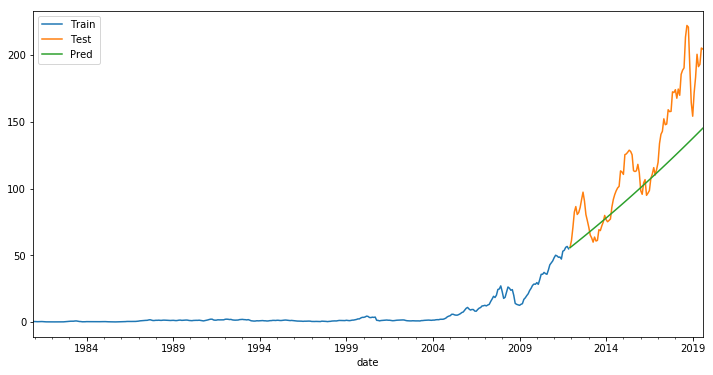

In [94]:
train.plot(figsize = (12,6) , legend = True , label = 'Train');
test.plot(figsize = (12,6) , legend = True , label = 'Test');
arima_pred.plot(figsize = (12,6) , legend = True , label = 'Pred');

In [96]:
#Evaluation 
print('Mean absolute error : '  , mean_absolute_error(test,arima_pred))
print('Mean squared error : '  , mean_squared_error(test,arima_pred))
print('Root mean squared error : '  , np.sqrt(mean_squared_error(test,arima_pred)))
print('Actual Mean :' , test.mean())

Mean absolute error :  24.28123186839908
Mean squared error :  1017.4151956329227
Root mean squared error :  31.896946493871834
Actual Mean : 120.67495419186754


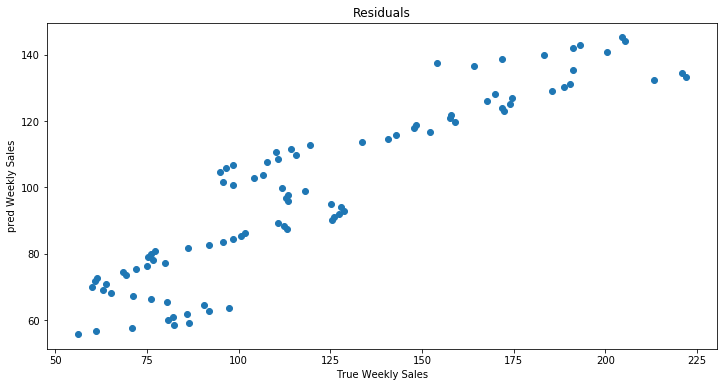

In [97]:
residuals =  y_true.values - arima_pred.values
plt.scatter(y_true.values, arima_pred.values)
plt.xlabel("True Weekly Sales")
plt.ylabel('pred Weekly Sales')
plt.title("Residuals")
plt.show()

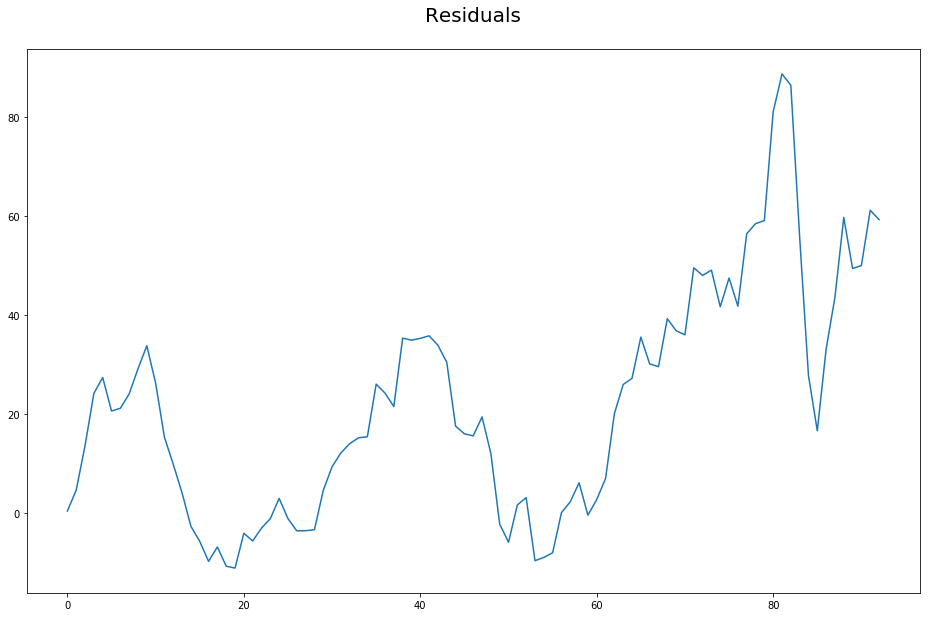

In [98]:
plt.figure(figsize=(16, 10))
plt.title("Residuals\n", fontdict={"fontsize":20})
plt.plot(residuals)
plt.show()

In [99]:
#forecast the future
arima_model_future = ARIMA(stocks_AAPL_close['close'] , order = (4, 2, 2)).fit()
arima_future = arima_model_future.predict(start = len(stocks_AAPL_close['close']) , 
                                          end = len(stocks_AAPL_close['close']) + 12  , typ ='levels')

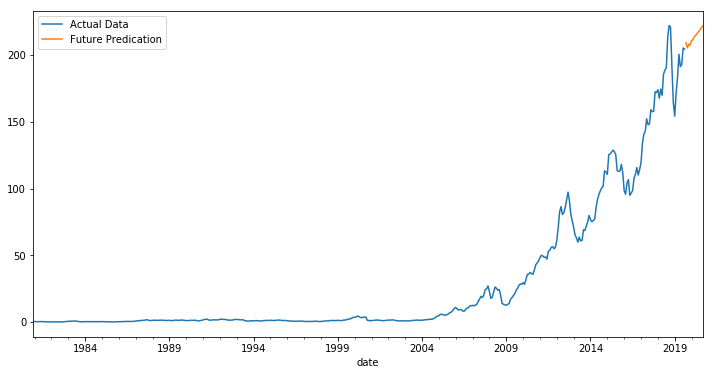

In [100]:
stocks_AAPL_close['close'].plot(figsize = (12,6) , legend = True , label = 'Actual Data');
arima_future.plot(figsize = (12,6) , legend = True , label = 'Future Predication');

#### Rolling Forecast

In [101]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4, 2, 2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()[0]
    predictions.append(output[0])
    obs = test[t]
    history.append(obs)

In [102]:
error = mean_squared_error(test, predictions)
predictions_ser = pd.Series(predictions , index = test.index)
print('Test MSE: %.3f' % error)

Test MSE: 69.320


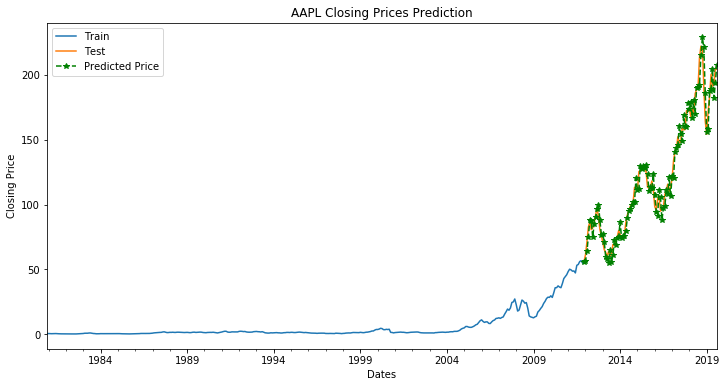

In [110]:
train.plot(figsize = (12,6) , legend = True , label = 'Train');
test.plot(figsize = (12,6) , legend = True , label = 'Test');
# predictions_ser.plot(figsize = (12,6) , legend = True , label = 'Pred')
predictions_ser.plot(figsize = (12,6) , legend = True , color ='green', marker='*', linestyle='dashed', 
         label='Predicted Price')
plt.title('AAPL Closing Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Closing Price');
